# 케라스 함수형 API 실습 - California Housing

이 노트북은 아래 문서에 실려 있는 예제를 실습하면서 작성한 것입니다.

* [How to Use the Keras Functional API?](https://levelup.gitconnected.com/how-to-use-the-keras-functional-api-4da8efec3392) - Tirendaz AI

## 데이터 준비

캘리포니아 주택 가격 데이터를 적재하고 훈련용과 시험용으로 나눕니다.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
print(f'feature_names: {housing.feature_names}')

X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, random_state=42)

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

feature_names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
X_train.shape: (15480, 8)
X_test.shape: (5160, 8)
y_train.shape: (15480,)
y_test.shape: (5160,)


## 모델 구성

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*Ur0Z1_uwRCtUmiPDheHkdg.png)

출처: [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

데이터 특성 8개 중에서 앞 부분 5개는 **Input wide**로, 뒷 부분 6개는 **Input deep**으로 입력하여 모델 내에서 서로 다른 경로를 거치게 하고 출력 전 단계에서 합칩니다.

2024-03-13 16:37:01.077289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 16:37:01.159916: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-13 16:37:01.161957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-13 16:37:01.161968: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

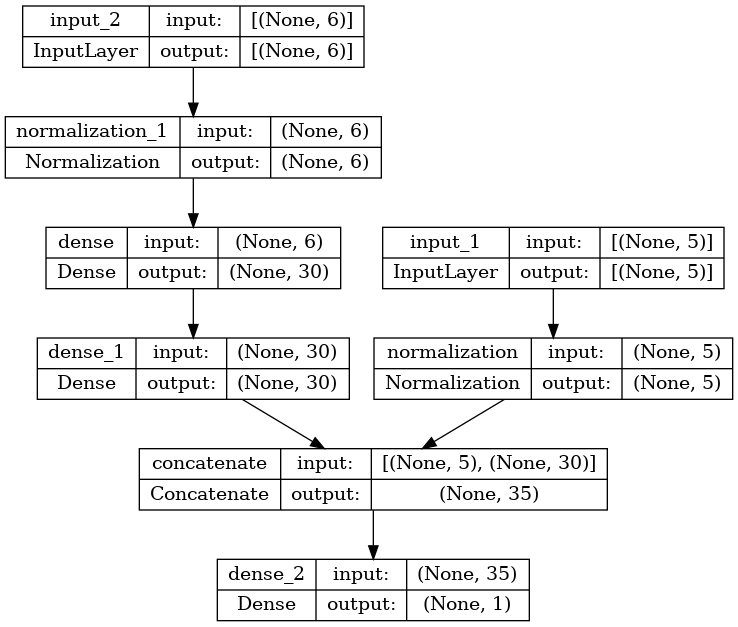

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Normalization, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

tf.random.set_seed(42)

input_wide = Input(shape=[5])
input_deep = Input(shape=[6])

norm_layer_wide = Normalization()
norm_layer_deep = Normalization()

norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)

hidden1 = Dense(30, activation='relu')(norm_deep)
hidden2 = Dense(30, activation='relu')(hidden1)

concat = concatenate([norm_wide, hidden2])

output = Dense(1)(concat)

model = Model(inputs=[input_wide, input_deep], outputs=[output])

plot_model(model, show_shapes=True)

## 훈련 및 평가

모델을 컴파일합니다.

In [3]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse', metrics=['RootMeanSquaredError'])

Input wide와 Input deep을 위한 훈련 데이터를 준비합니다.

In [4]:
X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]

정규화 계층에서 사용할 평균과 표준편차를 훈련 데이터를 토대로 계산하게 합니다.

In [5]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)

훈련 데이터를 지정하고 훈련을 시작합니다.

In [6]:
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
387/387 [==============================] - 1s 947us/step - loss: 1.5340 - root_mean_squared_error: 1.2385 - val_loss: 0.7432 - val_root_mean_squared_error: 0.8621
Epoch 2/20
387/387 [==============================] - 0s 1ms/step - loss: 0.6005 - root_mean_squared_error: 0.7749 - val_loss: 0.5378 - val_root_mean_squared_error: 0.7333
Epoch 3/20
387/387 [==============================] - 0s 829us/step - loss: 0.4779 - root_mean_squared_error: 0.6913 - val_loss: 0.4761 - val_root_mean_squared_error: 0.6900
Epoch 4/20
387/387 [==============================] - 0s 698us/step - loss: 0.4239 - root_mean_squared_error: 0.6510 - val_loss: 0.4252 - val_root_mean_squared_error: 0.6520
Epoch 5/20
387/387 [==============================] - 0s 770us/step - loss: 0.3948 - root_mean_squared_error: 0.6283 - val_loss: 0.4014 - val_root_mean_squared_error: 0.6336
Epoch 6/20
387/387 [==============================] - 0s 1ms/step - loss: 0.3719 - root_mean_squared_error: 0.6099 - val_loss: 0.383

훈련 이력을 그래프로 보여줍니다.

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


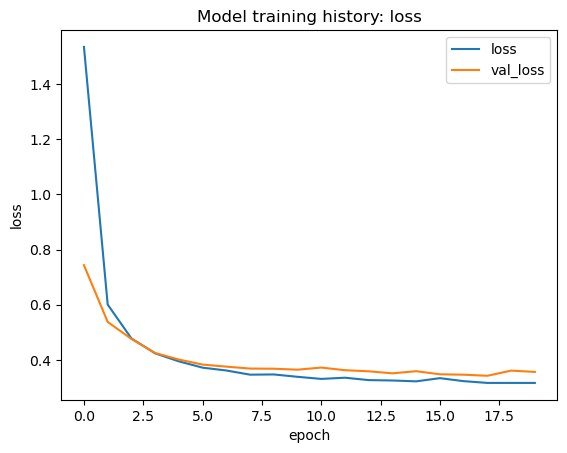

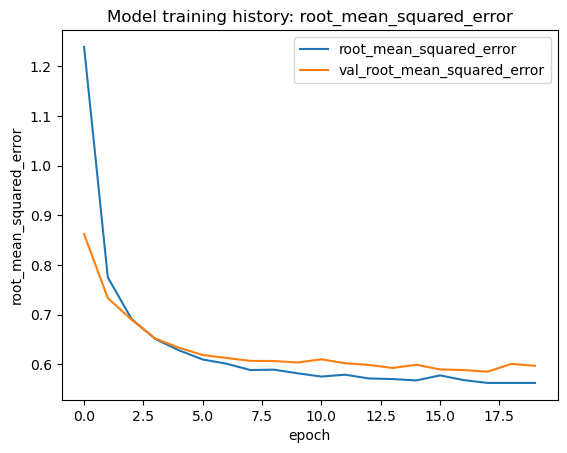

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model training history: loss')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.xlabel('epoch')
plt.ylabel('root_mean_squared_error')
plt.title('Model training history: root_mean_squared_error')
plt.legend(['root_mean_squared_error', 'val_root_mean_squared_error'], loc='upper right')
plt.show()

테스트 데이터를 사용하여 모델을 평가합니다.

In [8]:
test_scores = model.evaluate((X_test_wide, X_test_deep), y_test)

162/162 [==============================] - 0s 743us/step - loss: 0.3255 - root_mean_squared_error: 0.5706


## 예측

테스트 데이터 앞 부분 3개를 사용하여 주택 가격을 예측하고 참값과 비교해 봅니다.

In [9]:
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

y_pred = model.predict((X_new_wide, X_new_deep))
print(y_pred)

1/1 [==============================] - 0s 45ms/step
[[0.49146792]
 [1.1435364 ]
 [3.704099  ]]


In [10]:
print(y_test[:3])

[0.477   0.458   5.00001]
